In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/乙二醇加权利润-7DMA.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet[sheet['Date'] >= '2023-01-01']
sheet = sheet.set_index('Date')
last_day = sheet['MEG（含进口美金货）加权利润/7DMA'].last_valid_index()
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
# 所有数据截止到target_end
sheet = sheet[sheet.index <= target_end]

sheet['乙二醇港口+聚酯工厂总库存_提前8天'] = sheet['乙二醇港口+聚酯工厂总库存'].shift(8)
sheet['乙二醇港口+聚酯工厂总库存_提前8天'] = sheet['乙二醇港口+聚酯工厂总库存_提前8天'].interpolate(method='linear')
sheet = sheet.reset_index().rename(columns={'index': 'Date'})
sheet['Date'] = pd.to_datetime(sheet['Date'])

sheet.tail()

,Date,MEG（含进口美金货）加权利润/7DMA,乙二醇港口+聚酯工厂总库存,乙二醇港口+聚酯工厂总库存_提前8天
1043,2025-11-17,NaN,NaN,153.4004
1044,2025-11-18,NaN,NaN,153.4004
1045,2025-11-19,NaN,NaN,153.4004
1046,2025-11-20,NaN,NaN,153.4004
1047,2025-11-21,NaN,NaN,153.4004


In [5]:
file_path2  = 'eta/乙二醇加权利润残差拟合-总库存_合并数据.xlsx'
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
# 将真实值和预测值列合并为一个列
sheet2['乙二醇加权利润残拟合残差-总库存'] = sheet2['真实值'].fillna(sheet2['预测值'])
# 删除原始的真实值和预测值列
sheet2 = sheet2.drop(columns=['真实值', '预测值'])
sheet2.head()

,Date,乙二醇加权利润残拟合残差-总库存
0,2025-11-21,-12.8289
1,2025-11-20,-2.6203
2,2025-11-19,-0.6826
3,2025-11-18,-15.2681
4,2025-11-17,4.6451


In [6]:
# 确保Date列是日期类型
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
merged_df_2 = pd.merge(sheet, sheet2, on='Date', how='left')
sheet_daily = merged_df_2.copy()
sheet_daily = sheet_daily.dropna(subset=['乙二醇港口+聚酯工厂总库存_提前8天', '乙二醇加权利润残拟合残差-总库存'])

sheet_daily.tail()

,Date,MEG（含进口美金货）加权利润/7DMA,乙二醇港口+聚酯工厂总库存,乙二醇港口+聚酯工厂总库存_提前8天,乙二醇加权利润残拟合残差-总库存
1043,2025-11-17,NaN,NaN,153.4004,4.6451
1044,2025-11-18,NaN,NaN,153.4004,-15.2681
1045,2025-11-19,NaN,NaN,153.4004,-0.6826
1046,2025-11-20,NaN,NaN,153.4004,-2.6203
1047,2025-11-21,NaN,NaN,153.4004,-12.8289


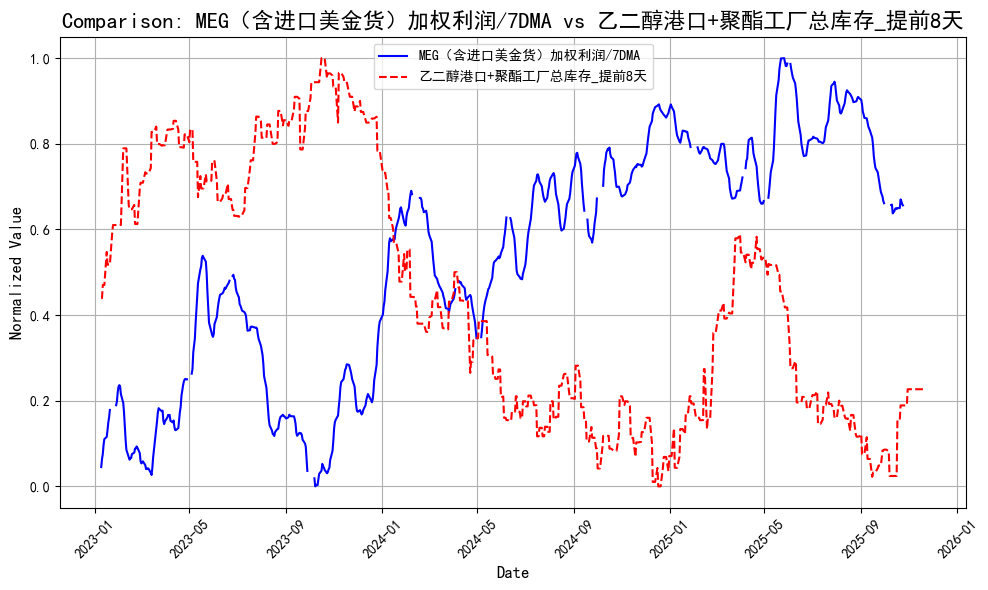

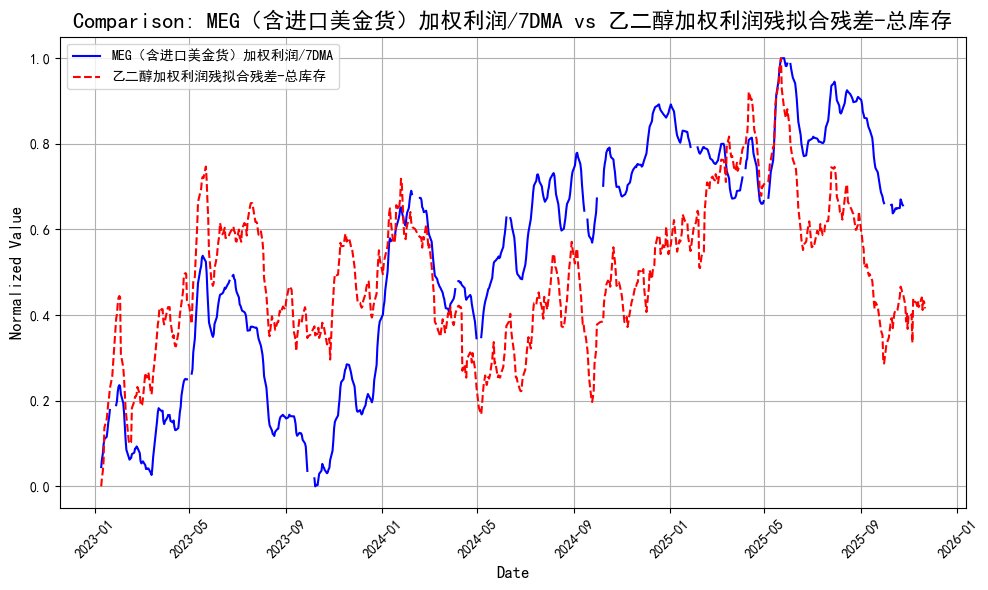

In [7]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='MEG（含进口美金货）加权利润/7DMA', 
    compare_cols=['乙二醇港口+聚酯工厂总库存_提前8天','乙二醇加权利润残拟合残差-总库存']
)

In [8]:
# 添加新列 PX-WTI价差_预测
sheet_daily['MEG（含进口美金货）加权利润/7DMA_预测'] = -5.5569* sheet_daily['乙二醇港口+聚酯工厂总库存_提前8天'] + 363.5740 + sheet_daily['乙二醇加权利润残拟合残差-总库存']
sheet_daily.tail()

,Date,MEG（含进口美金货）加权利润/7DMA,乙二醇港口+聚酯工厂总库存,乙二醇港口+聚酯工厂总库存_提前8天,乙二醇加权利润残拟合残差-总库存,MEG（含进口美金货）加权利润/7DMA_预测
1043,2025-11-17,NaN,NaN,153.4004,4.6451,-484.211583
1044,2025-11-18,NaN,NaN,153.4004,-15.2681,-504.124783
1045,2025-11-19,NaN,NaN,153.4004,-0.6826,-489.539283
1046,2025-11-20,NaN,NaN,153.4004,-2.6203,-491.476983
1047,2025-11-21,NaN,NaN,153.4004,-12.8289,-501.685583


In [9]:
last_day = sheet_daily['Date'][sheet_daily['MEG（含进口美金货）加权利润/7DMA'].last_valid_index()]


# 创建每日数据框
merged_df_daily = pd.DataFrame()
merged_df_daily['Date'] = sheet_daily['Date']
merged_df_daily['真实值'] = sheet_daily['MEG（含进口美金货）加权利润/7DMA']
merged_df_daily['预测值'] = None

# 在last_day之后填充预测值
mask = merged_df_daily['Date'] > last_day
merged_df_daily.loc[mask, '预测值'] = sheet_daily.loc[mask, 'MEG（含进口美金货）加权利润/7DMA_预测']

# 创建月度数据框 
merged_df_montly = pd.DataFrame()
merged_df_montly['Date'] = sheet_daily['Date']
merged_df_montly['真实值'] = sheet_daily['MEG（含进口美金货）加权利润/7DMA']
merged_df_montly['预测值'] = None

# 在2024-01-01之后填充预测值
mask = merged_df_montly['Date'] > '2024-01-01'
merged_df_montly.loc[mask, '预测值'] = sheet_daily.loc[mask, 'MEG（含进口美金货）加权利润/7DMA_预测']


In [10]:
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/乙二醇加权利润_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_daily

,Date,真实值,预测值
1047,2025/11/21,NaN,-501.685583
1046,2025/11/20,NaN,-491.476983
1045,2025/11/19,NaN,-489.539283
1044,2025/11/18,NaN,-504.124783
1043,2025/11/17,NaN,-484.211583
...,...,...,...
12,2023/01/13,-898.0256,None
11,2023/01/12,-908.2952,None
10,2023/01/11,-925.0842,None
9,2023/01/10,-933.7703,None


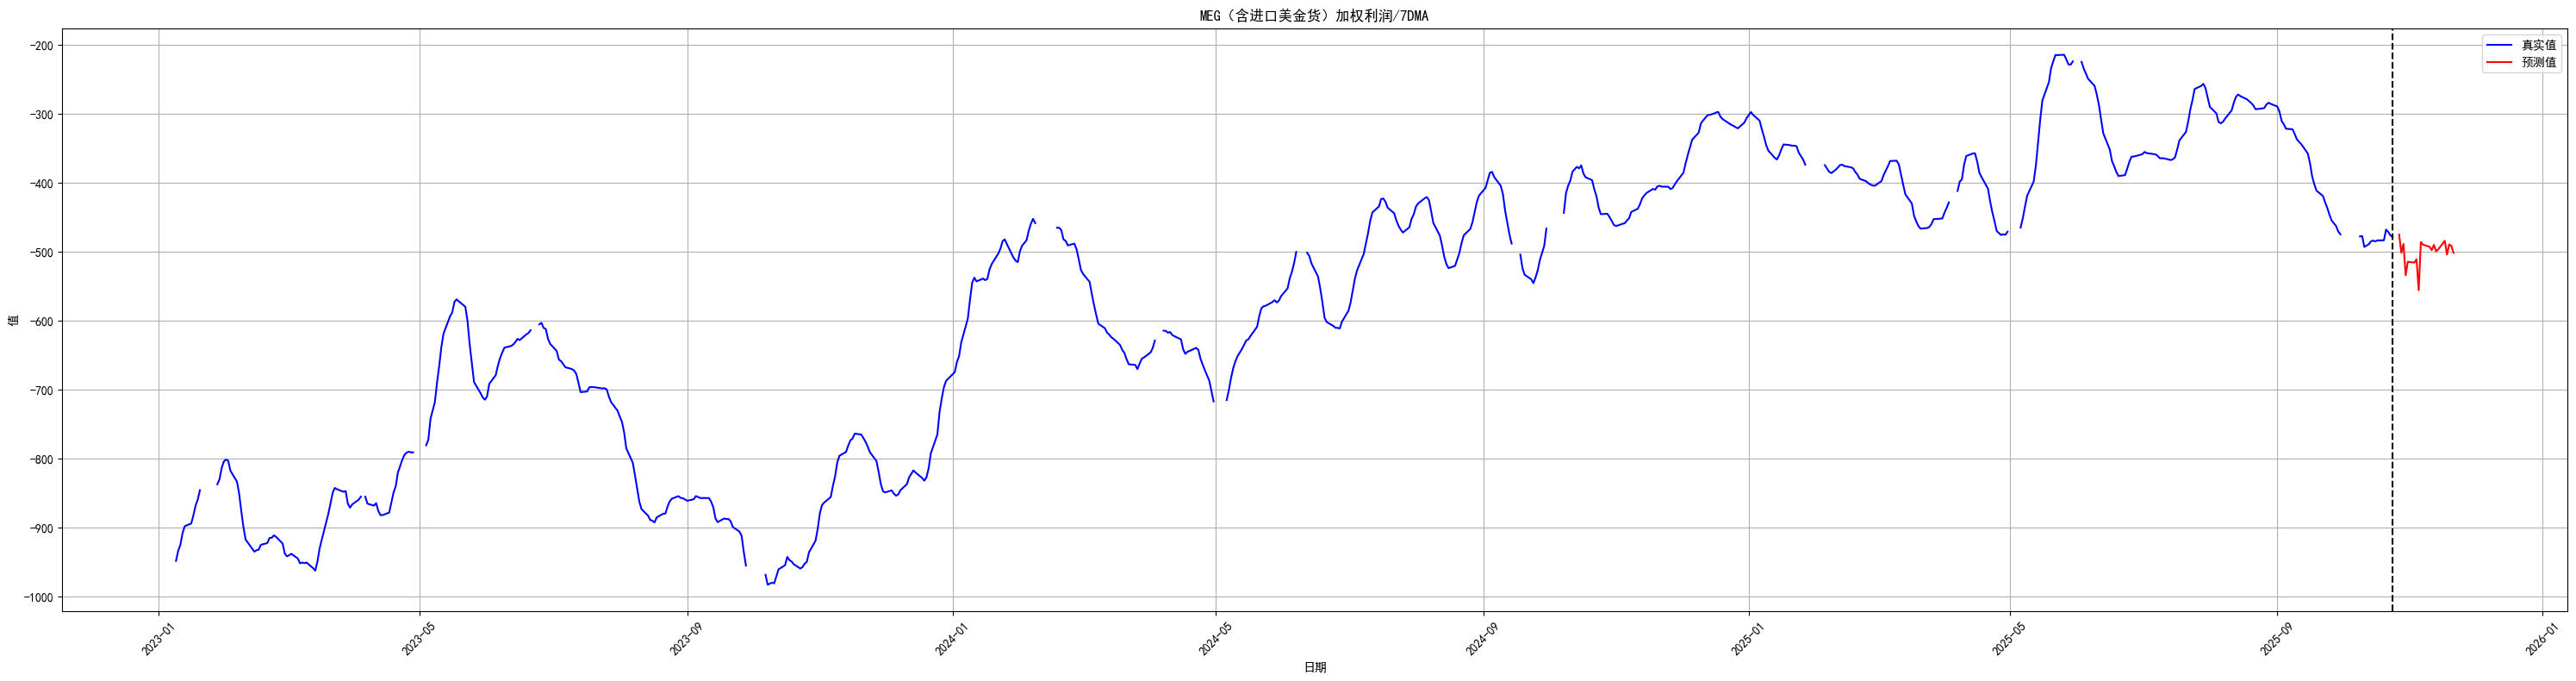

In [11]:
# 设置图形大小
plt.figure(figsize=(30, 8))
merged_df_daily_plot = merged_df_daily
# 将日期格式转换回datetime格式用于绘图
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['真实值'], color='blue', label='真实值')
# 绘制预测值曲线(红色) 
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['预测值'], color='red', label='预测值')
# 计算并绘制中间垂直线(黑色)
avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()
plt.title('MEG（含进口美金货）加权利润/7DMA')
plt.xlabel('日期')
plt.ylabel('值')

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
merged_df_montly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_montly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/乙二醇加权利润_月度数据.xlsx', index=False,float_format= '%.0f')
merged_df_monthly.head()

,Date,真实值,预测值
34,2025/11/30,NaN,-500.378476
33,2025/10/31,-480.950762,-450.191625
32,2025/09/30,-379.708709,-383.997583
31,2025/08/31,-290.467367,-305.809542
30,2025/07/31,-328.627822,-330.875133


---

In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "MEG加权利润"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "详情页"
identifier = "MEG加权利润"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
